<a href="https://colab.research.google.com/github/bryantosin1/PCVK_WEEK7/blob/main/Kuis_2_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kuis 2 - Praktikum**

Silakan mengerjakan pertanyaan di bawah ini dengan benar dan jujur.

1. Mengerjakan secara kelompok yang terdiri dari 3 anggota
2. Kumpulkan e-ktp anggota keluarga pada kelompok minimal 10 buah sebagai dataset.
3. deteksi dan kenali foto wajah e-ktp tersebut menggunakan metode yang telah dipelajari baik pada matakulilah PCVK ataupun matakuliah lain pada semester ini.
4. Presentasikan di depan kelas hasil dari pekerjaan kelompok Anda, paparkan hasil dari pekerjaan tersebut secara detail lengkap dengan tangkapan layar bagian dari; (1)pre-processing, (2)lokalisasi, (3)segmentasi, dan (4)pengenalan.
5. jangan lupa upload juga kode program tersebut pada repository
6. kumpulkan link file presentasi dalam bentuk pdf dan link repository.

NAMA KELOMPOK 3 :

1. Aura Sagita Ashilah  (2141720102)

2. Bryan tosin Saputro (2141720220)

3. Masfudin Dwi Cahyo   (2141720010)

In [1]:
# akses drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode

In [4]:
# Tahap Pre Processing
def biggest_contour(contours):
    biggest = None  # Initialize as None
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

img = cv2.imread('/content/drive/MyDrive/PCVK/ktp/ktp.png')
img_original = img.copy()

gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(gray, (5, 5), 0.5)

# Otsu Thresholding
thresholded = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply Dilation
kernel_dilation = np.ones((5, 5), np.uint8)
dilated_img = cv2.dilate(thresholded, kernel_dilation, iterations=1)

# Apply Erosion
kernel_erosion = np.ones((5, 5), np.uint8)
eroded_img = cv2.erode(dilated_img, kernel_erosion, iterations=1)

# Apply Opening (Erosion followed by Dilation)
kernel_opening = np.ones((5, 5), np.uint8)
opening_img = cv2.morphologyEx(eroded_img, cv2.MORPH_OPEN, kernel_opening)

In [5]:
# Lokalisasi (Canny)
edged = cv2.Canny(opening_img, 50, 150)

In [6]:
# Initialize input_points outside the conditional block
input_points = np.zeros((4, 2), dtype="float32")

# Segmentasi
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
biggest = biggest_contour(contours)

# Check if the biggest contour is found before attempting to draw
if biggest is not None:
    cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

    # Warp Perspective
    points = biggest.reshape(4, 2)

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))



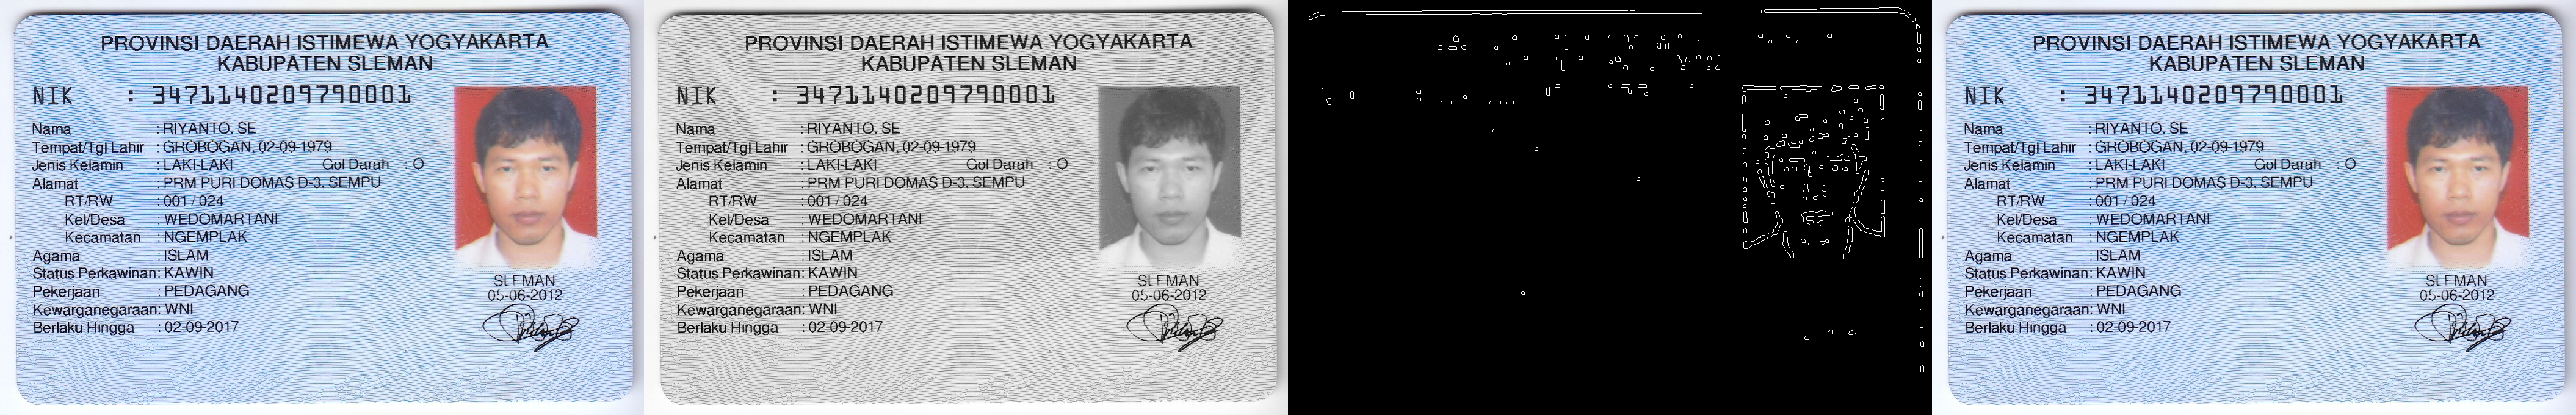

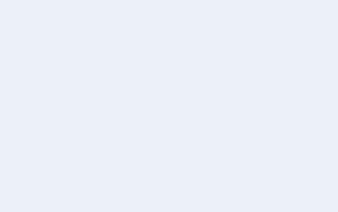

In [7]:
# Output gambar setelah Warp Prespective
ktp_width = 8.6  # Lebar KTP dalam cm
ktp_height = 5.4  # Tinggi KTP dalam cm

max_width = int(ktp_width * 100 / 2.54)
max_height = int(ktp_height * 100 / 2.54)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

# Image shape modification for hstack
gray = np.stack((gray,) * 3, axis=-1)
edged = np.stack((edged,) * 3, axis=-1)

img_hor = np.hstack((img_original, gray, edged, img))
cv2_imshow(img_hor)
cv2_imshow(img_output)

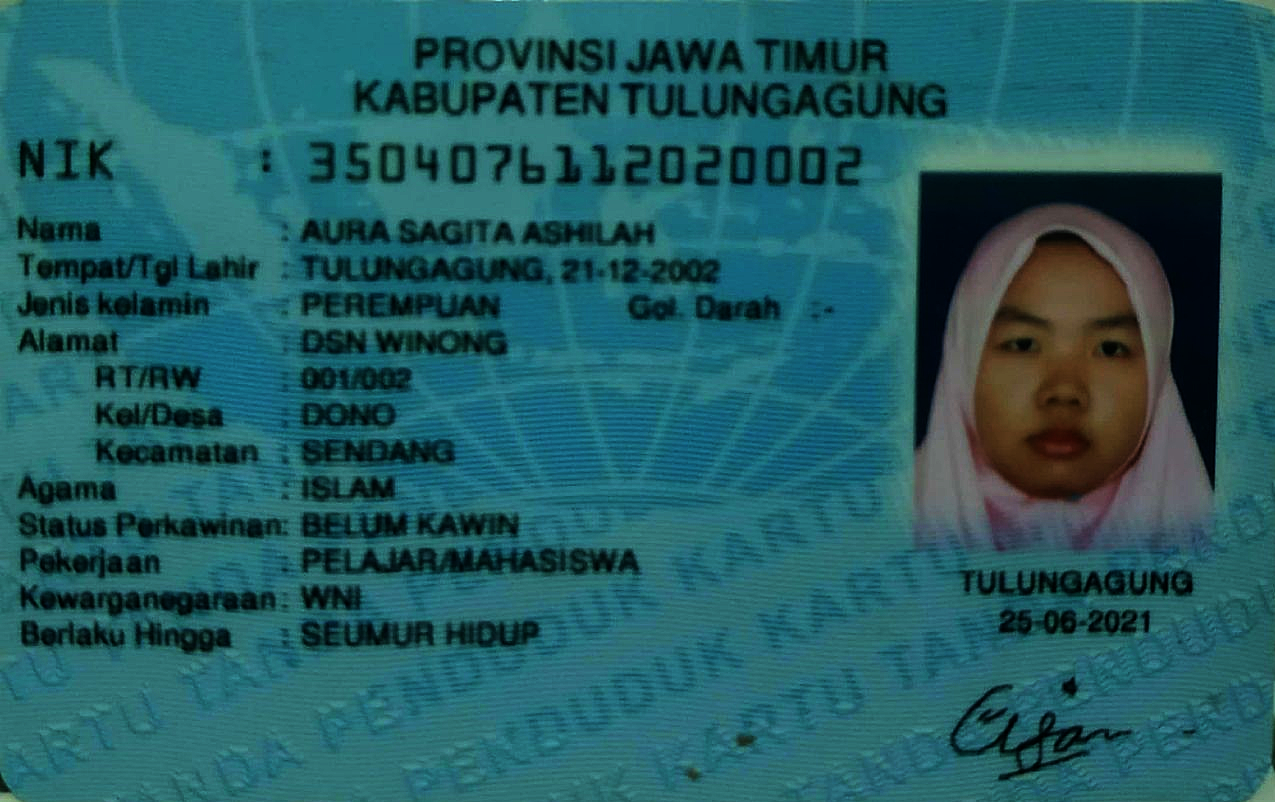

In [ ]:
img = cv2.imread('/content/drive/MyDrive/PCVK/KTP Keluarga/KTP_fix.jpg')
img_ori = img.copy()

# Tahap Sharpening
def gamma_correction(image, gamma):
    inv_gamma = 1 / gamma
    gamma_image = np.clip((image / 255) ** inv_gamma * 255, 0, 255).astype(np.uint8)
    return gamma_image

def convolution2d(image, kernel):
    return cv2.filter2D(image, -1, kernel)

kernel_sharpen = np.array([[1, 4, 6, 4, 1],
                                [4, 16, 24, 16, 4],
                                [6, 24, -476, 24, 6],
                                [4, 16, 24, 16, 4],
                                [1, 4, 6, 4, 1]], dtype=np.float32) * -1 / 256

result = np.copy(img_ori)
ktp_result = gamma_correction(result, 0.5)
ktp_filtered = convolution2d(ktp_result, kernel_sharpen)

cv2_imshow(ktp_filtered)

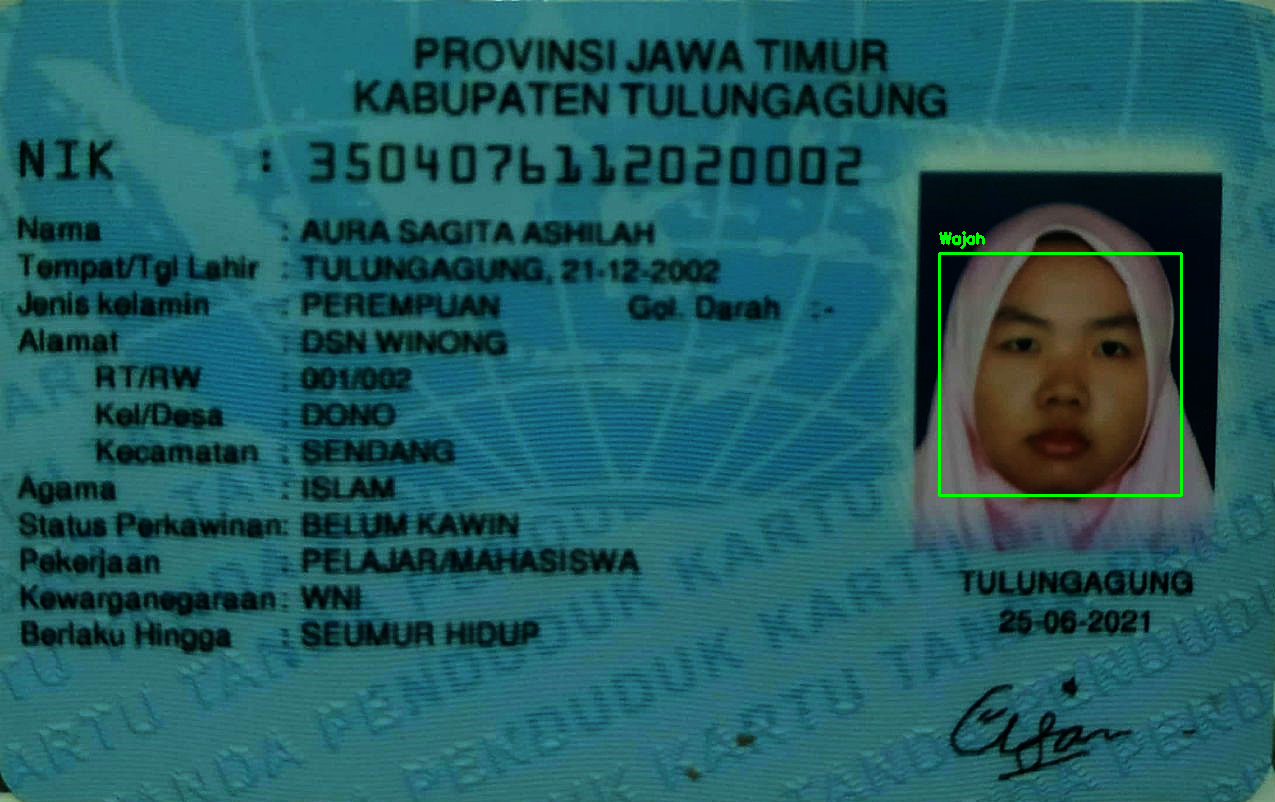

In [ ]:
# Tahap Deteksi
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/PCVK/haarcascade_frontalface_alt.xml')
detect = np.copy(ktp_filtered)
gray = cv2.cvtColor(detect, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(20, 20))

for (x, y, w, h) in faces:
    cv2.rectangle(detect, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Menampilkan teks "Wajah" di atas kotak deteksi
    cv2.putText(detect, 'Wajah', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2_imshow(detect)

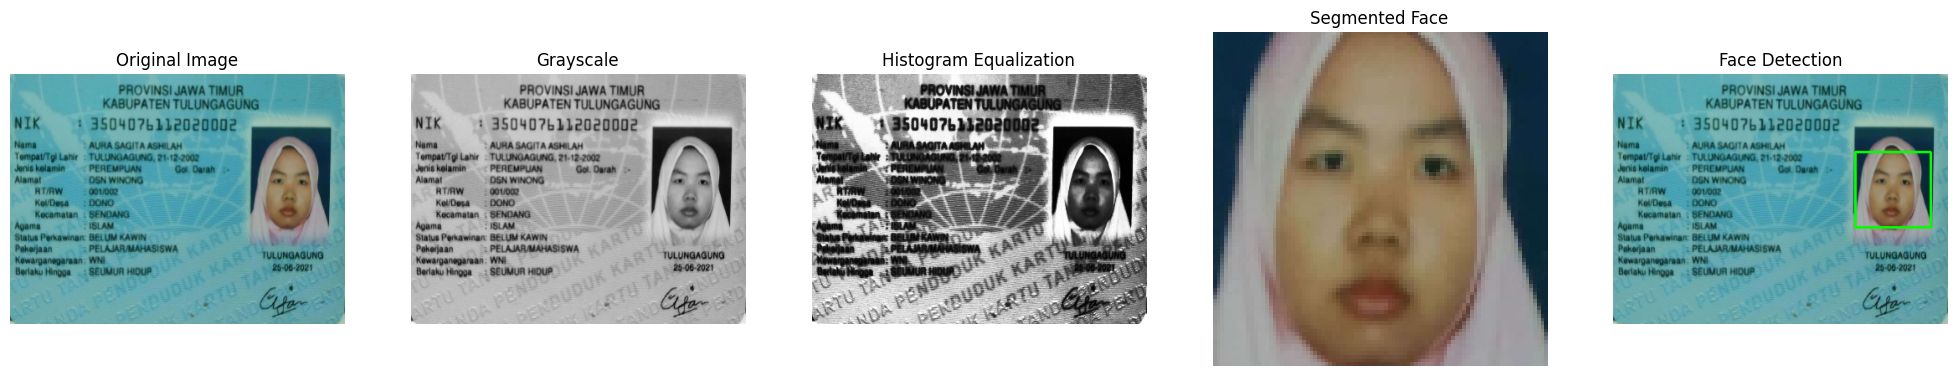

In [ ]:
# Direktori tempat gambar berada
img_path = '/content/drive/MyDrive/PCVK/KTP Keluarga/KTP_fix.jpg'

# Load Haar Cascade classifier for face detection
cascade_wajah = cv2.CascadeClassifier('/content/drive/MyDrive/PCVK/haarcascade_frontalface_alt.xml')

# Membaca gambar dari path
img = cv2.imread(img_path)

# PREPROCESSING
# (1) Resize the image
img = cv2.resize(img, (400, 300))

# (2) Convert to Grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# (3) Histogram Equalization
equalized_img = cv2.equalizeHist(gray_img)

# (4) Lokalisasi (Face Detection)
faces = cascade_wajah.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# SEGEMENTASI DAN RECOGNIZATION
for (x, y, w, h) in faces:
    # (5) Segmentasi (Crop Wajah)
    face_segment = img[y:y+h, x:x+w]

    # Tampilkan hasil segmentasi dan pengenalan wajah
    plt.figure(figsize=(25, 6))

    # Gambar asli
    plt.subplot(151)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Grayscale image (PREPROCESSING)
    plt.subplot(152)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Equalized Image (PREPROCESSING)
    plt.subplot(153)
    plt.imshow(equalized_img, cmap='gray')
    plt.title('Histogram Equalization')
    plt.axis('off')

    # Gambar Segmentasi Wajah
    plt.subplot(154)
    plt.imshow(cv2.cvtColor(face_segment, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Face')
    plt.axis('off')

    # Gambar dengan kotak di sekitar wajah (Lokalisasi - Face Detection)
    img_with_boxes = img.copy()
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.subplot(155)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title('Face Detection')
    plt.axis('off')

    plt.show()


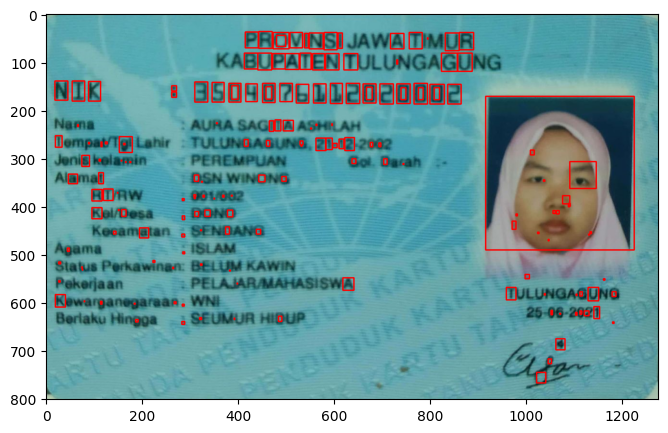

In [ ]:
import os

# load data
img = cv2.imread('/content/drive/MyDrive/PCVK/KTP Keluarga/KTP_fix.jpg')
blurred = cv2.GaussianBlur(img, (5, 5), 0.5)

gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
ret, bw = cv2.threshold(gray.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

erode = cv2.erode(bw.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (1, 1)))

# Ekstraksi kontur
contours, hierarchy = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Looping contours untuk mendapatkan kontur yang sesuai
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    ras = format(w / h, '.2f')
    if h >= 4 and w >= 1 and float(ras) <= 1:
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)
    elif h >= 2 and w >= 1 and float(ras) <= 1:
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

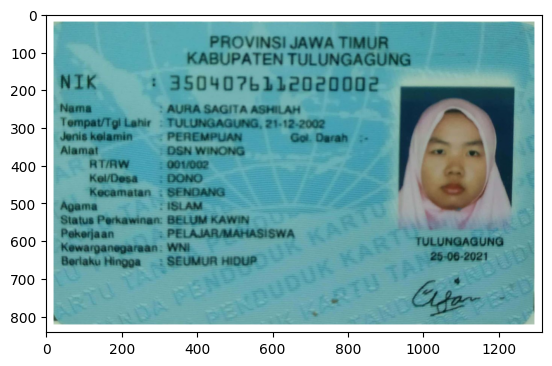

In [ ]:
ktp = cv2.imread('/content/drive/MyDrive/PCVK/KTP Keluarga/KTP_fix.jpg')
ktp = cv2.copyMakeBorder(
	src=ktp,
	top=20,
	bottom=20,
	left=20,
	right=20,
	borderType=cv2.BORDER_CONSTANT,
	value=(255, 255, 255))
plt.imshow(cv2.cvtColor(ktp, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()

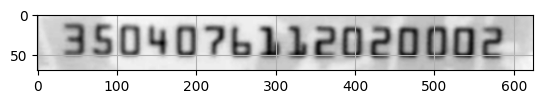

In [ ]:
ktp_gray = cv2.cvtColor(ktp, cv2.COLOR_BGR2GRAY)
ktp_blur = cv2.GaussianBlur(
                src=ktp_gray,
                ksize=(5, 5),
                sigmaX=0,
                sigmaY=0)
ktp_crop = ktp_blur[150:220, 295:920]
plt.imshow(ktp_crop, cmap='gray')
plt.grid(True)
plt.show()

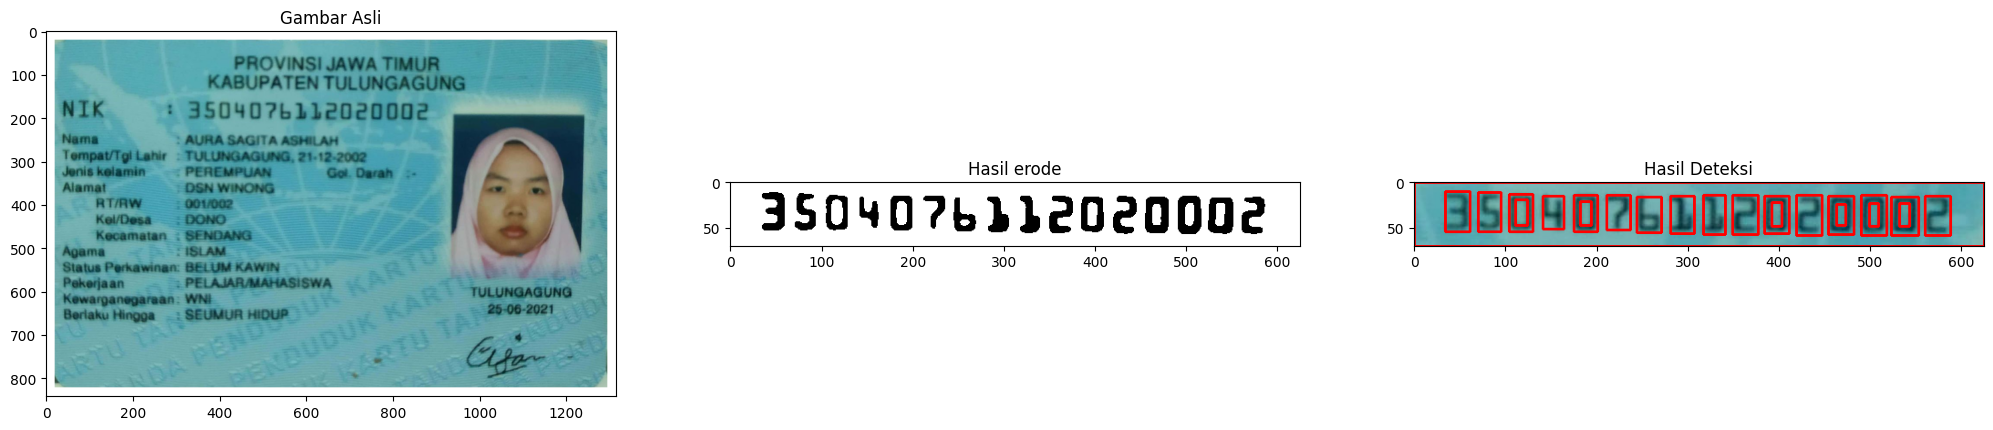

In [ ]:
output = ktp[150:220, 295:920].copy()
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
gray = clahe.apply(ktp_crop)
ret, bw = cv2.threshold(gray.copy(), 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# make more clear using closing
kernel = np.ones((3,3), np.uint8)
closing = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=1)
dilate = closing.copy()



# Ekstraksi kontur
contours, hierarchy = cv2.findContours(dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Looping contours untuk mendapatkan kontur yang sesuai
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    ras = format(w / h, '.2f')
    if h >= 40 and w >= 10 and float(ras) <= 1:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)
    elif h >= 8 and w >= 8 and float(ras) <= 10:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)
    elif h >= 10 and w >= 7 and float(ras) <= 8:
      cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)

      # cv.drawContours(ktp, contours, -1, (0, 255, 0), 2)

# Menampilkan gambar KTP dengan kontur menggunakan plt
f, axarr = plt.subplots(1, 3, figsize=(25, 8))
axarr[0].imshow(cv2.cvtColor(ktp, cv2.COLOR_BGR2RGB))
axarr[0].set_title("Gambar Asli")
axarr[1].imshow(dilate, cmap='gray')
axarr[1].set_title("Hasil erode")
axarr[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axarr[2].set_title("Hasil Deteksi")
plt.show()

